#📌 Extracción

In [225]:
import pandas as pd

In [226]:
# Leer archivo y convertir a un DataFrame
df = pd.read_json('/TelecomX_Data.json')
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


#🔧 Transformación

## **Conoce el conjunto de datos**

In [227]:
# Ver columnas
df.columns

Index(['customerID', 'Churn', 'customer', 'phone', 'internet', 'account'], dtype='object')

In [228]:
# Verificar tipo de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


Columnas: 'Churn', 'customer', 'phone', 'internet', 'account'.
Todas de tipo object.

## **Comprobacion de incoherencias en los datos**

In [229]:
# verificar valores nulos
df.isnull().sum()

,0
customerID,0
Churn,0
customer,0
phone,0
internet,0
account,0


In [230]:
# contar duplicados
df['customerID'].duplicated().sum()

np.int64(0)

Hay 4 columnas anidadas y entre ellas 1 tiene otra dentro suyo. No hay valores duplicados ni nulos en la tabla original. Se tienen que normalizar las columnas anidadas y crear columnas nuevas.

## Manejo de Inconsistencias

In [231]:
# Verificar que tiene la columna account
df['account'].iloc[0]

{'Contract': 'One year',
 'PaperlessBilling': 'Yes',
 'PaymentMethod': 'Mailed check',
 'Charges': {'Monthly': 65.6, 'Total': '593.3'}}

In [232]:
# Normalizar cada columna con diccionario

customer_df = pd.json_normalize(df['customer']).add_prefix('customer.')
phone_df = pd.json_normalize(df['phone']).add_prefix('phone.')
internet_df = pd.json_normalize(df['internet']).add_prefix('internet.')

# Para 'account', normalizar primero y usar sep para anidar las claves 'Charges'
account_df = pd.json_normalize(df['account'], sep='_').add_prefix('account.')

# Ahora juntar todo en un df
# quitar columnas originales
df = df.drop(columns=['customer', 'phone', 'internet', 'account'])

# Concatenar dfs normalizados
df_clean = pd.concat([df, customer_df, phone_df, internet_df, account_df], axis=1)

# Verificar resultado
df_clean.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges_Monthly,account.Charges_Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


## Columna cuenta diaria

In [233]:
df_clean['Cuentas_Diarias'] = df_clean['account.Charges_Monthly'] / 30
df_clean.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges_Monthly,account.Charges_Total,Cuentas_Diarias
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3,2.186667
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4,1.996667
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4,2.796667


## Estandarizacion y transformacion de datos

In [234]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

In [235]:
# CAMBIAR TIPOS
# Mapa para convertir valores de texto a booleanos
map_si_no = {'Yes': True, 'No': False, 'True': True, 'False': False}

# Convertir customerID a str
df_clean['customerID'] = df_clean['customerID'].astype('string')

# Convertir columnas binarias a booleano
cols_binarias = [
    'Churn',
    'customer.Partner',
    'customer.Dependents',
    'phone.PhoneService',
    'account.PaperlessBilling'
]

for col in cols_binarias:
    df_clean[col] = df_clean[col].replace(map_si_no).astype(bool)

# Convertir columna account.Charges_Total a float
df_clean['account.Charges_Total'] = pd.to_numeric(df_clean['account.Charges_Total'], errors='coerce')

# Convertir columnas categóricas a tipo category
cols_categoricas = [
    'customer.gender', 'phone.MultipleLines', 'internet.InternetService',
    'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection',
    'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies',
    'account.Contract', 'account.PaymentMethod'
]

for col in cols_categoricas:
    df_clean[col] = df_clean[col].astype('category')

<ipython-input-235-348e09365138>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean[col] = df_clean[col].replace(map_si_no).astype(bool)
<ipython-input-235-348e09365138>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean[col] = df_clean[col].replace(map_si_no).astype(bool)
<ipython-input-235-348e09365138>:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future b

In [236]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   customerID                 7267 non-null   string  
 1   Churn                      7267 non-null   bool    
 2   customer.gender            7267 non-null   category
 3   customer.SeniorCitizen     7267 non-null   int64   
 4   customer.Partner           7267 non-null   bool    
 5   customer.Dependents        7267 non-null   bool    
 6   customer.tenure            7267 non-null   int64   
 7   phone.PhoneService         7267 non-null   bool    
 8   phone.MultipleLines        7267 non-null   category
 9   internet.InternetService   7267 non-null   category
 10  internet.OnlineSecurity    7267 non-null   category
 11  internet.OnlineBackup      7267 non-null   category
 12  internet.DeviceProtection  7267 non-null   category
 13  internet.TechSupport       7267 n

In [237]:
# renombrar columnas
df_clean.rename(columns={
    'customerID': 'ID_Cliente',
    'Churn': 'Desercion',
    'customer.gender': 'Genero',
    'customer.SeniorCitizen': 'AdultoMayor',
    'customer.Partner': 'Pareja',
    'customer.Dependents': 'Dependientes',
    'customer.tenure': 'AntiguedadMeses',
    'phone.PhoneService': 'ServicioTelefono',
    'phone.MultipleLines': 'LineasMultiples',
    'internet.InternetService': 'ServicioInternet',
    'internet.OnlineSecurity': 'SeguridadOnline',
    'internet.OnlineBackup': 'RespaldoOnline',
    'internet.DeviceProtection': 'ProteccionDispositivo',
    'internet.TechSupport': 'SoporteTecnico',
    'internet.StreamingTV': 'StreamingTV',
    'internet.StreamingMovies': 'StreamingPeliculas',
    'account.Contract': 'Contrato',
    'account.PaperlessBilling': 'FacturacionSinPapel',
    'account.PaymentMethod': 'MetodoPago',
    'account.Charges_Monthly': 'CobroMensual',
    'account.Charges_Total': 'CobroTotal',
    'Cuentas_Diarias': 'CobroDiario'
}, inplace=True)


#📊 Carga y análisis

## Analisis Descriptivo

In [238]:
# Convertir CobroTotal a numérico (por si acaso hay errores)
df_clean['CobroTotal'] = pd.to_numeric(df_clean['CobroTotal'], errors='coerce')

# Variables numéricas para describir
variables_numericas = ['AntiguedadMeses', 'CobroMensual', 'CobroTotal', 'CobroDiario']

# Estadísticas descriptivas para variables numéricas
descripcion_numerica = df_clean[variables_numericas].describe().T
descripcion_numerica['mediana'] = df_clean[variables_numericas].median()

descripcion_numerica.head()

,count,mean,std,min,25%,50%,75%,max,mediana
AntiguedadMeses,7267.0,32.346498,24.571773,0.000000,9.000000,29.000000,55.000000,72.000000,29.000000
CobroMensual,7267.0,64.720098,30.129572,18.250000,35.425000,70.300000,89.875000,118.750000,70.300000
CobroTotal,7256.0,2280.634213,2268.632997,18.800000,400.225000,1391.000000,3785.300000,8684.800000,1391.000000
CobroDiario,7267.0,2.157337,1.004319,0.608333,1.180833,2.343333,2.995833,3.958333,2.343333


## Distribucion de evasion

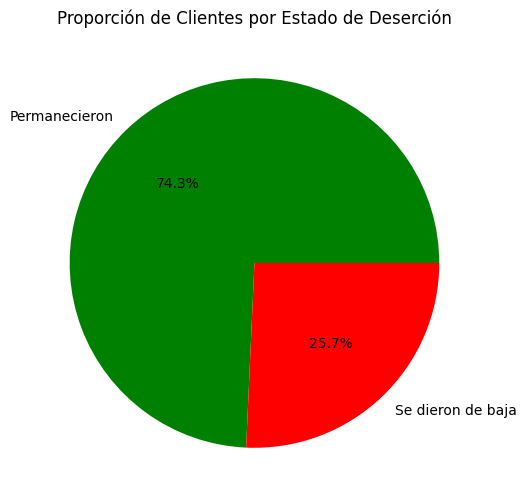

In [239]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contar los valores de la variable Desercion
conteo_desercion = df_clean['Desercion'].value_counts()

# Mapear los valores booleanos a etiquetas personalizadas
etiquetas = ['Permanecieron' if val == False else 'Se dieron de baja' for val in conteo_desercion.index]

# Definir colores con lógica
colors = ['green', 'red'] if False in conteo_desercion.index else ['red', 'green']

# Gráfico de pastel
plt.figure(figsize=(6,6))
plt.pie(
    conteo_desercion.values,
    labels=etiquetas,
    autopct='%1.1f%%',
    colors=colors
)
plt.title('Proporción de Clientes por Estado de Deserción')
plt.show()

## Recuento de evasion por variables categoricas

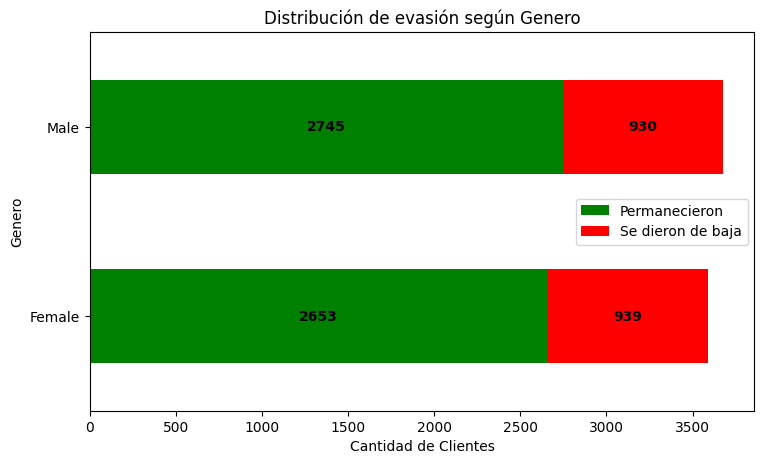

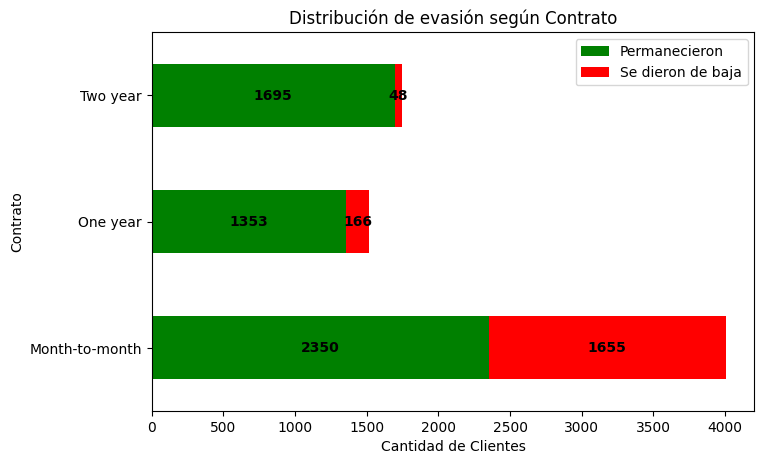

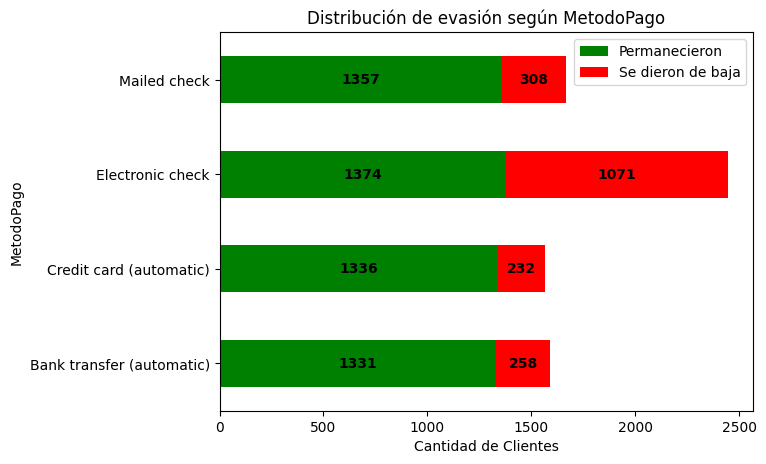

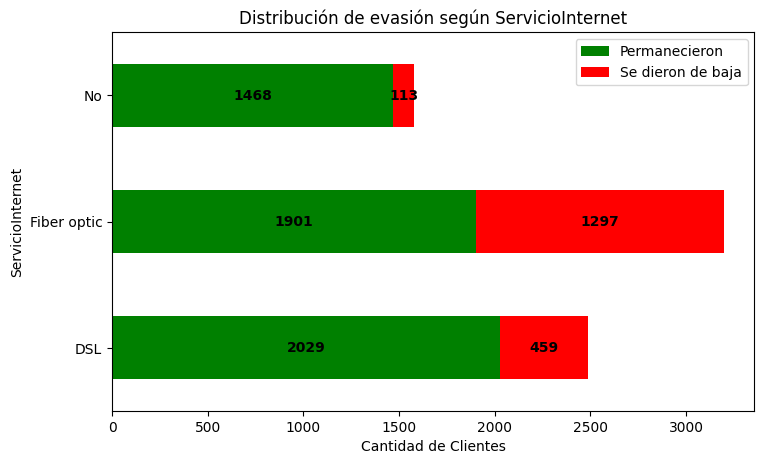

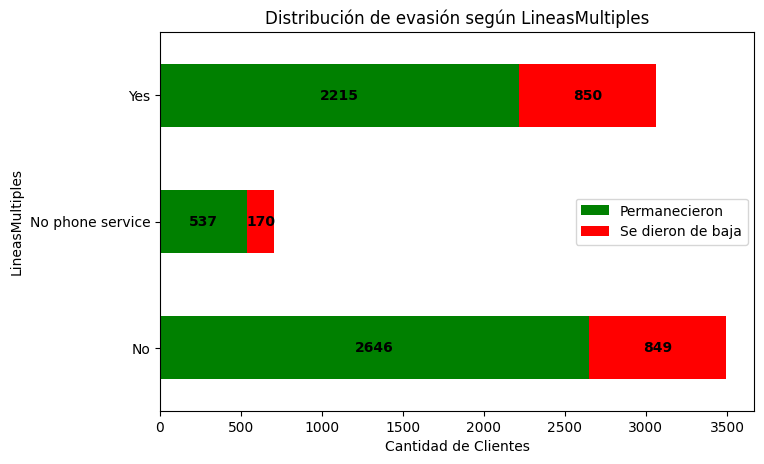

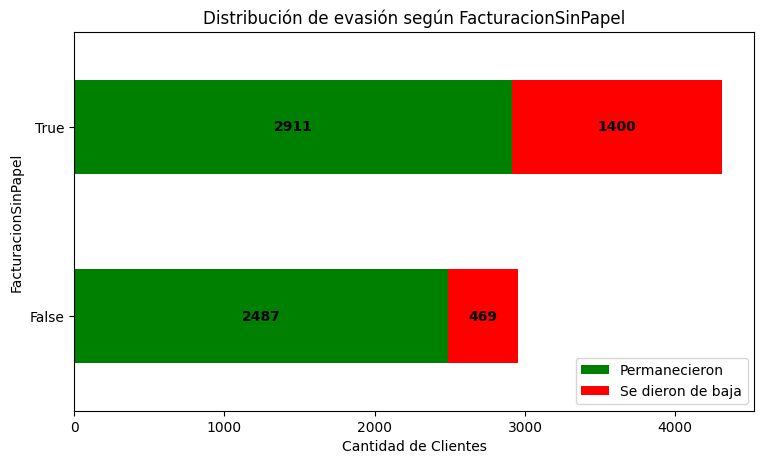

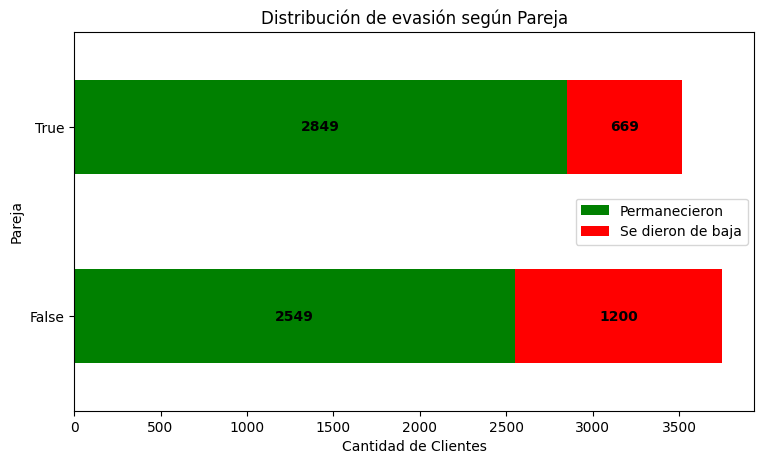

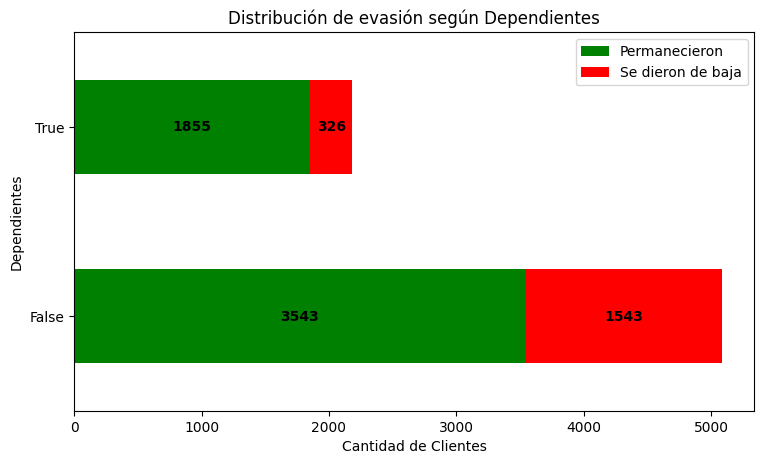

In [240]:
# Variables categóricas a analizar
variables_categoricas = [
    'Genero',
    'Contrato',
    'MetodoPago',
    'ServicioInternet',
    'LineasMultiples',
    'FacturacionSinPapel',
    'Pareja',
    'Dependientes'
]

# Gráficos de barras horizontales apiladas
for col in variables_categoricas:
    ct = pd.crosstab(df_clean[col], df_clean['Desercion'])  # conteo absoluto

    ax = ct.plot(kind='barh', stacked=True, figsize=(8, 5),
                 color={False: 'green', True: 'red'})

    # Añadir etiquetas dentro de las barras
    for p in ax.patches:
        width = p.get_width()
        if width > 0:
            x = p.get_x() + width / 2
            y = p.get_y() + p.get_height() / 2
            ax.text(x, y, f'{int(width)}', ha='center', va='center',
                    fontsize=10, color='black', fontweight='bold')

    plt.title(f'Distribución de evasión según {col}')
    plt.ylabel(col)
    plt.xlabel('Cantidad de Clientes')
    plt.legend(['Permanecieron', 'Se dieron de baja'])
    plt.tight_layout(pad=2)
    plt.show()
    print('\n' * 2)


## Conteo de evasión por variables numéricas

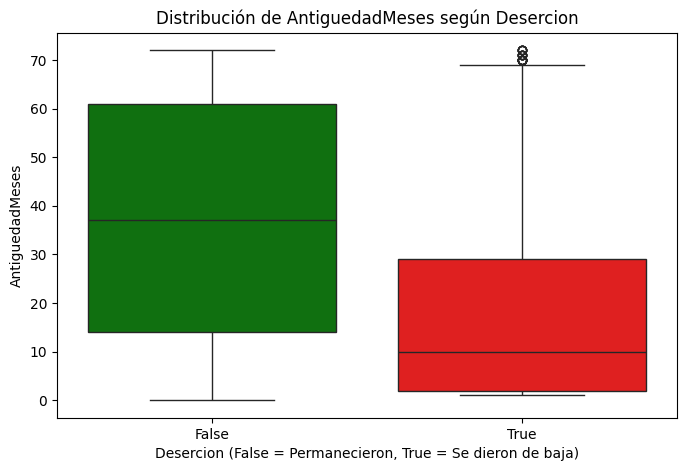

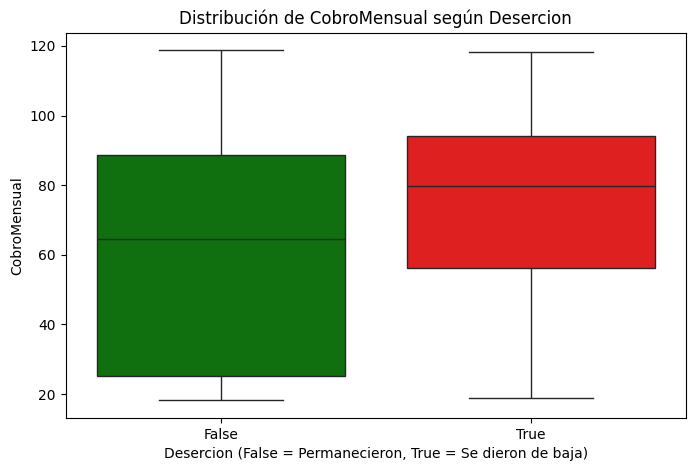

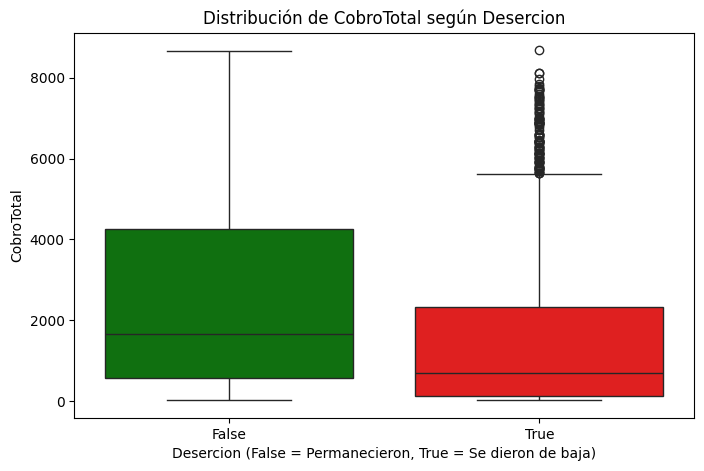

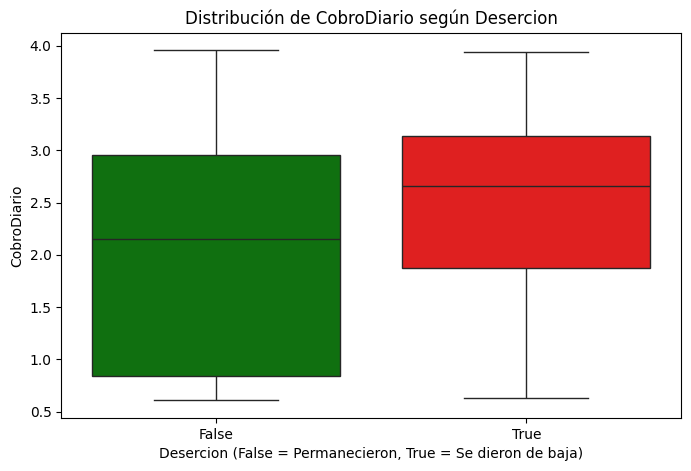

In [241]:
numericas = ['AntiguedadMeses', 'CobroMensual', 'CobroTotal', 'CobroDiario']

# Box charts

palette = {'False': "green", 'True': "red",False: "green", True: "red"}

for col in numericas:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df_clean, x='Desercion', y=col, hue='Desercion', palette=palette, legend=False)
    plt.title(f'Distribución de {col} según Desercion')
    plt.xlabel('Desercion (False = Permanecieron, True = Se dieron de baja)')
    plt.ylabel(col)
    plt.show()
    print('\n' * 2)

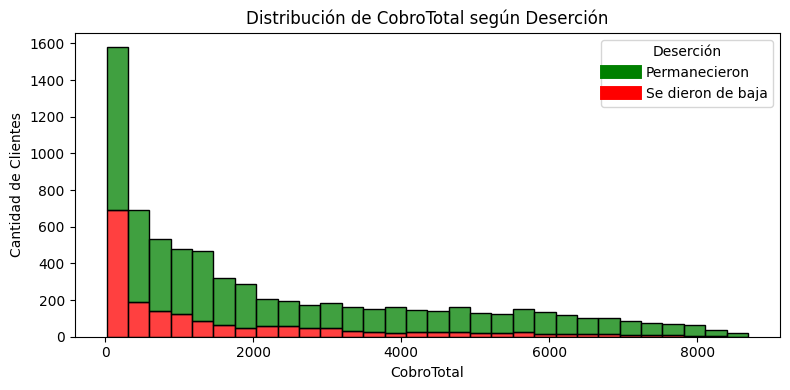

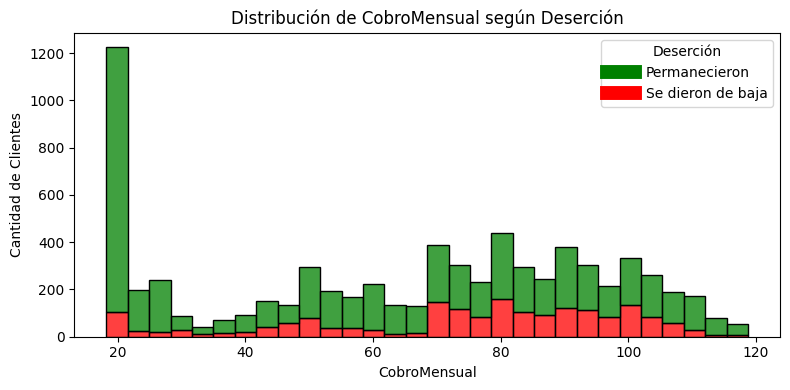

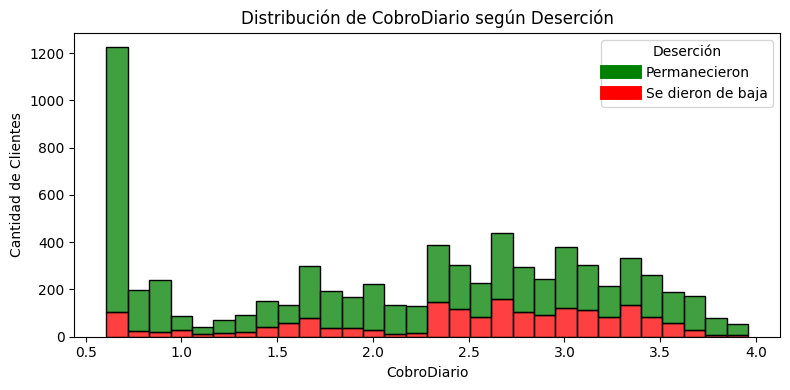

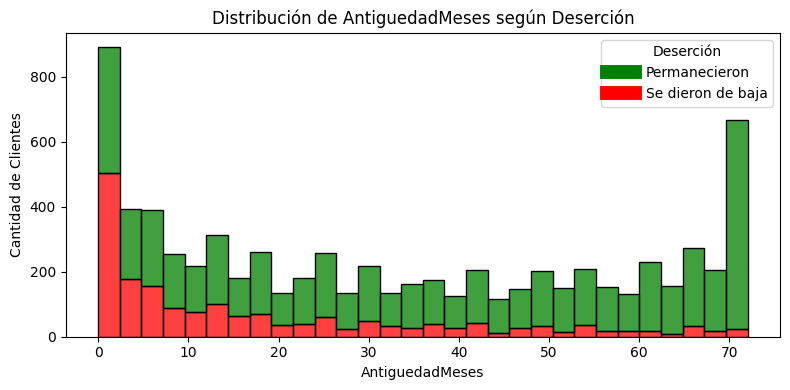

In [242]:
# histograma
num_cols = ['CobroTotal', 'CobroMensual', 'CobroDiario', 'AntiguedadMeses']
labels = {False: 'Permanecieron', True: 'Se dieron de baja'}

for col in num_cols:
    plt.figure(figsize=(8, 4))

    # configurar histograma acumulado con la paleta
    ax = sns.histplot(
        data=df_clean,
        x=col,
        hue='Desercion',
        multiple='stack',
        bins=30,
        palette=palette,
        legend=False  # para agregar la leyenda manualmente
    )

    # crear leyenda
    handles = [
        plt.Line2D([0], [0], color=palette[False], lw=10),
        plt.Line2D([0], [0], color=palette[True], lw=10)
    ]
    plt.legend(handles, [labels[False], labels[True]], title='Deserción')

    plt.title(f'Distribución de {col} según Deserción')
    plt.xlabel(col)
    plt.ylabel('Cantidad de Clientes')
    plt.tight_layout()
    plt.show()
    print('\n' * 2)

#📄Informe Final de Análisis de Evasión de Clientes (Churn)

## 1. Introducción

El objetivo de este análisis es entender el fenómeno de la evasión de clientes (churn) en la empresa, identificando patrones y variables que influyen en la decisión de los clientes de cancelar el servicio. A través del análisis de datos numéricos y categóricos, buscamos proporcionar insights valiosos para diseñar estrategias que reduzcan la tasa de deserción y mejoren la retención.

## 2. Limpieza y Tratamiento de Datos

Se trabajó con un conjunto de datos original que contenía variables numéricas y categóricas. Los pasos principales fueron:

*   Identificacion de datos y sus tipos
*   Validación de consistencia y corrección de datos atípicos.
*   Estandarizacion y transformacion de datos.
*   Creacion de columnas nuevas.
*   Conversión de tipos de datos.
*   Renombrado de columnas.

## 3. Análisis Exploratorio de Datos


### 3.1 Análisis descriptivo

| Variable            | Conteo | Media     | Desviación Estándar | Mínimo | 25%    | 50%    | 75%    | Máximo  | Mediana |
|---------------------|--------|-----------|-----------|-------|--------|--------|--------|---------|---------|
| Antigüedad (Meses)  | 7267   | 32.35     | 24.57     | 0     | 9      | 29     | 55     | 72      | 29      |
| Cobro Mensual       | 7267   | 64.72     | 30.13     | 18.25 | 35.43  | 70.30  | 89.88  | 118.75  | 70.30   |
| Cobro Total         | 7256   | 2280.63   | 2268.63   | 18.8  | 400.23 | 1391   | 3785.3 | 8684.8  | 1391    |
| Cobro Diario        | 7267   | 2.16      | 1.00      | 0.61  | 1.18   | 2.34   | 3.00   | 3.96    | 2.34    |

### 3.2 Proporción general de evasión

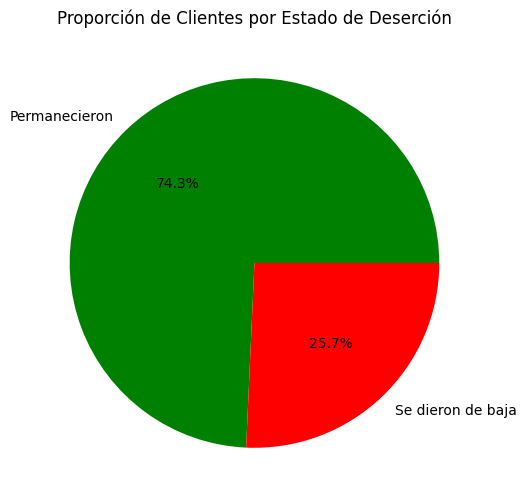

### 3.3 Distribución de evasión según variables categóricas

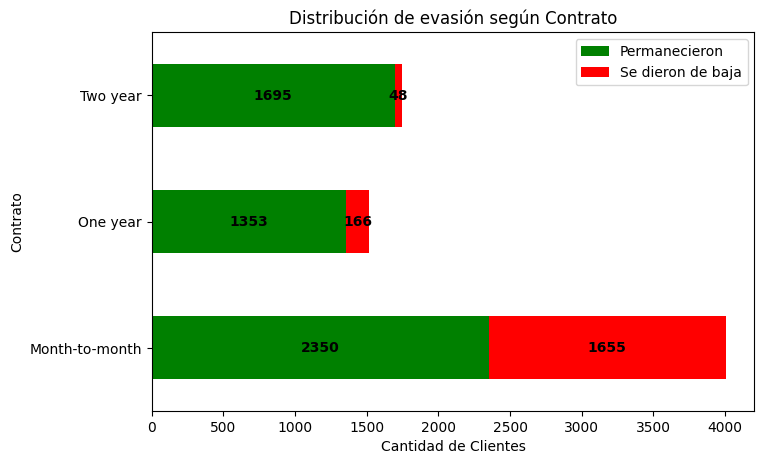

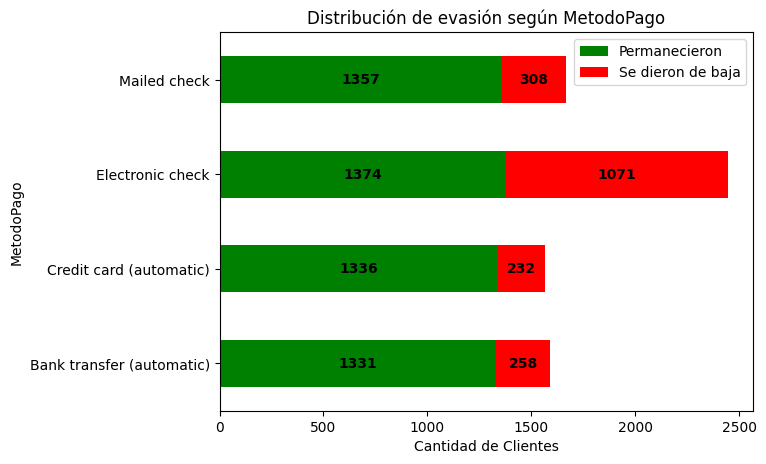

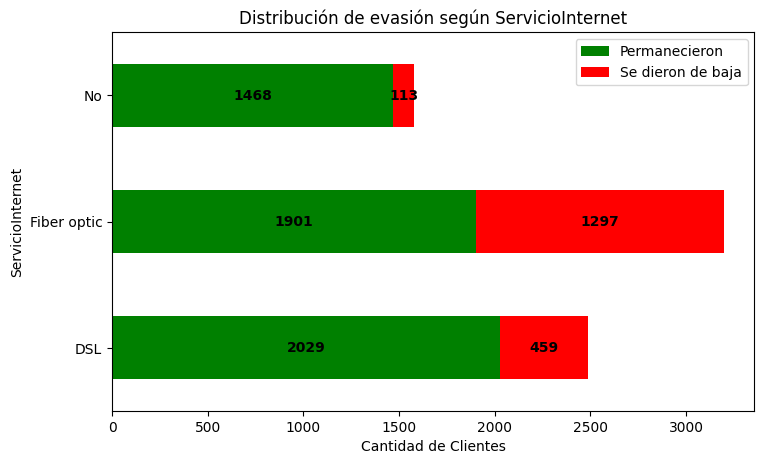

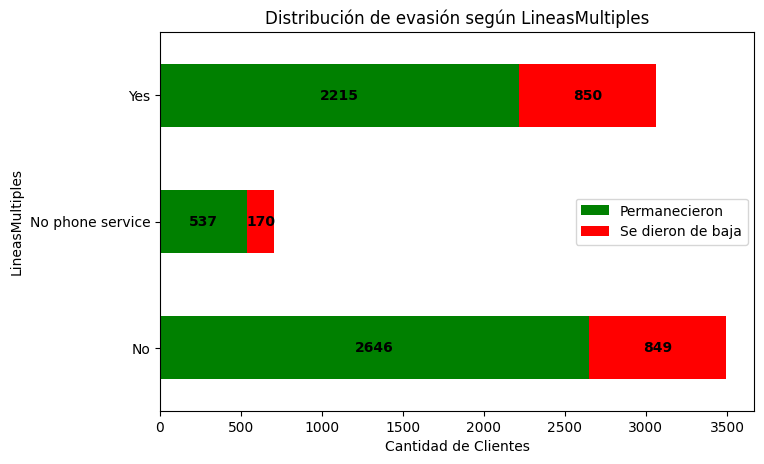

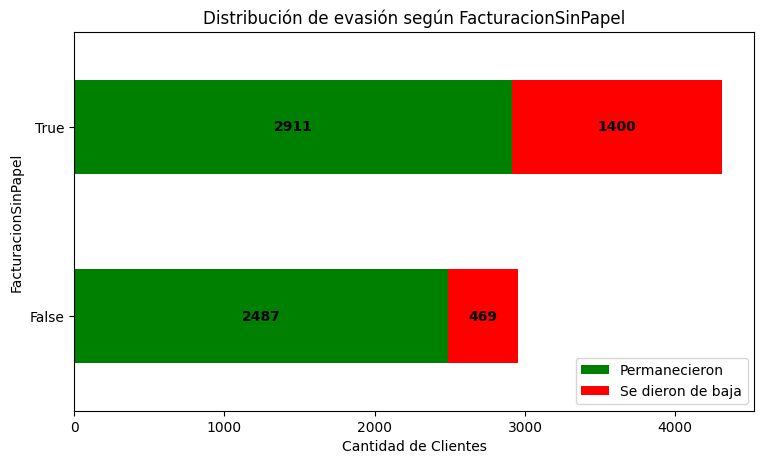

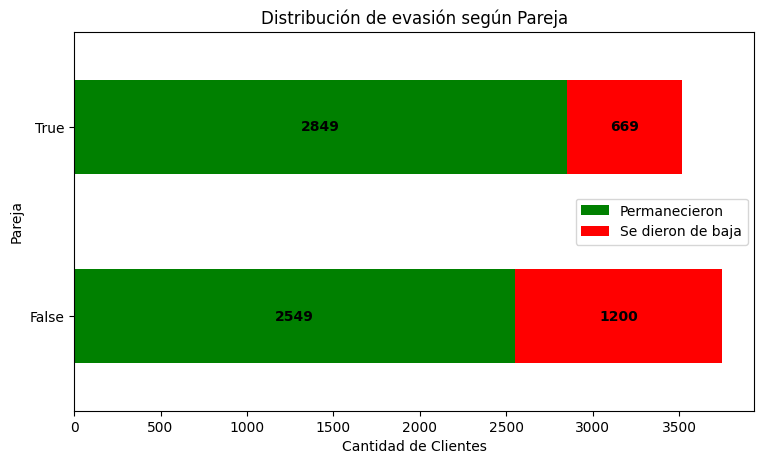

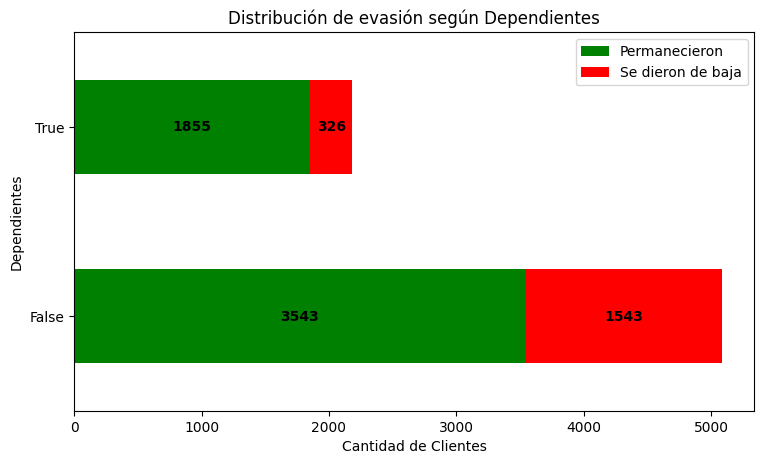

### 3.4 Distribución de variables numéricas según deserción (Boxplots)

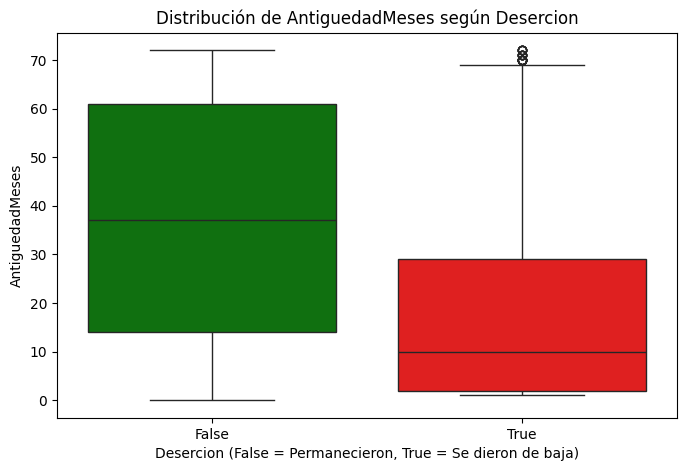

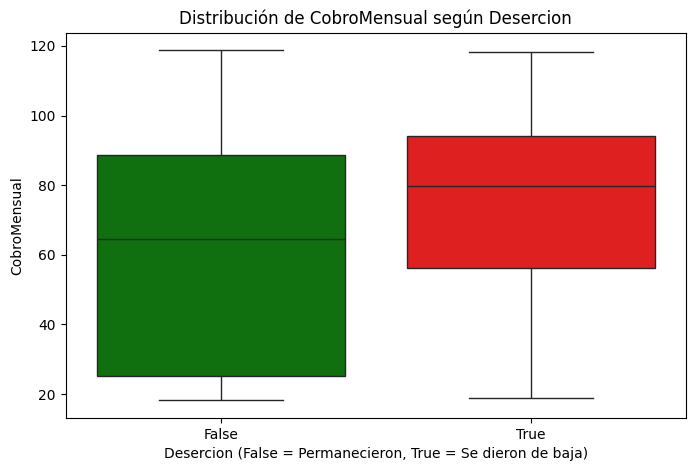

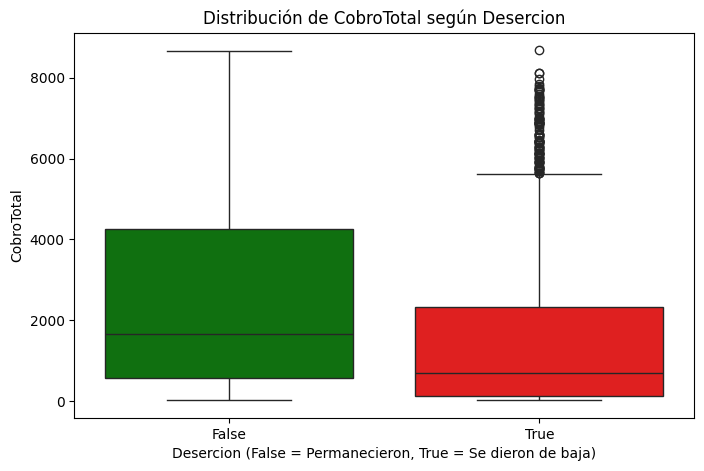

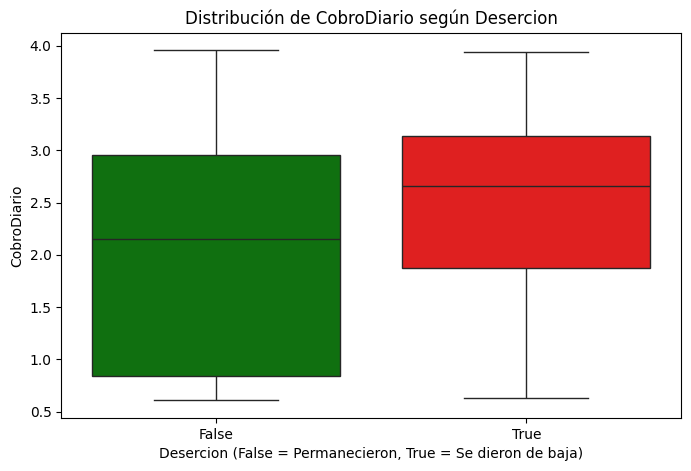

### 3.5 Histograma y tendencias clave

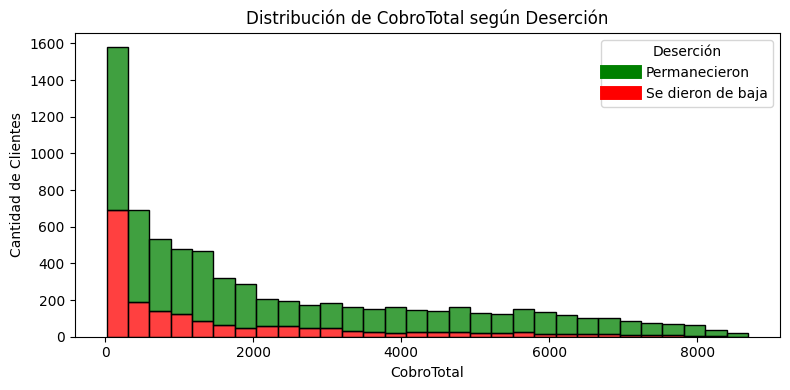

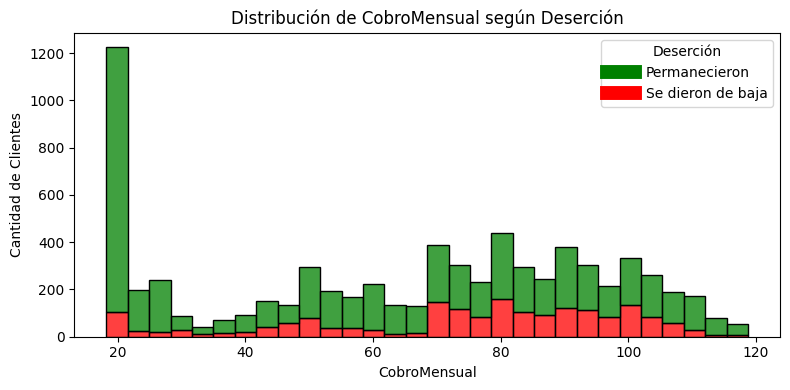

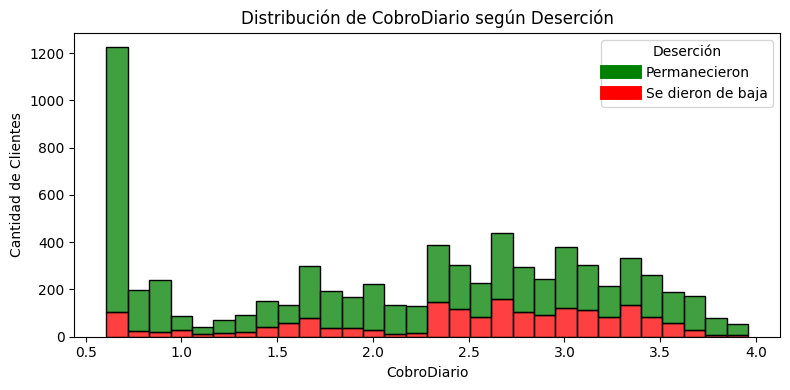

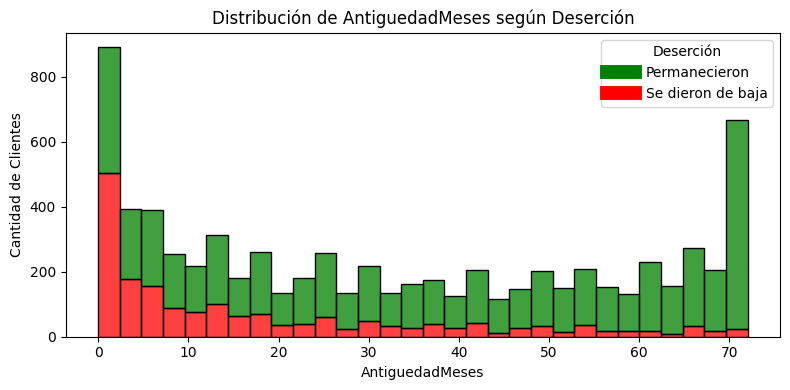

## 4. Conclusiones e Insights

*   La mayoría de clientes que se dan de baja tienen contratos mes a mes (1655 bajas), mientras que solo 48 clientes con contrato de dos años se dieron de baja, lo que demuestra que la fidelización a largo plazo es altamente efectiva para retener clientes.

*   El método de pago también es un factor determinante. El cheque electrónico presenta 1071 bajas, casi la mitad del total de deserciones, mientras que métodos automáticos como transferencias bancarias (258 bajas) o tarjeta de crédito (232 bajas) presentan tasas mucho menores.

*   En cuanto al servicio de internet, la fibra óptica tiene 1297 clientes que se dieron de baja, lo que la convierte en el tipo de conexión con más deserciones, a pesar de ser popular. Esto puede deberse a costos elevados o expectativas no cumplidas.

*   Los clientes sin líneas múltiples presentan una tasa de deserción ligeramente menor (849 de 3495 ≈ 24.3%) comparado con los que tienen líneas múltiples (850 de 3065 ≈ 27.7%). Aunque los valores son similares, esto sugiere que contar con varias líneas no garantiza mayor retención.

*   En cuanto a la facturación sin papel, aunque más clientes que la utilizan permanecen (2911) que los que no la usan (2487), también tienen más deserciones absolutas (1400 vs. 469). Esto puede indicar que la facturación digital es popular, pero no necesariamente se relaciona con una mayor retención.

*   La antigüedad del cliente es un predictor clave: quienes han estado más tiempo con la empresa tienen muchas más probabilidades de quedarse. Por ejemplo, la mediana de antigüedad de los que permanecen es de aproximadamente 38 meses, mientras que para los que se dan de baja es de aproximadamente 10 meses.

*   Clientes que pagan menos mensualmente (debajo de 70) o por día (debajo de 2.4) tienen una mayor tasa de permanencia. A partir de esos valores —70 en cobro mensual y 2.4 en cobro diario— comienza a observarse una tendencia creciente de deserción.

*   Finalmente, aunque los clientes que pagan poco tienden a cancelar con más frecuencia, también hay clientes de alto valor que abandonan, lo cual indica que deben considerarse otros factores como la satisfacción del cliente, la atención y el soporte técnico.

## 5. Recomendaciones

*   **Promover contratos a largo plazo:** Ofrecer incentivos y beneficios claros para que los clientes opten por contratos anuales o bienales.

*   **Optimizar métodos de pago:** Facilitar y promover métodos automáticos y seguros, reduciendo el uso de cheques electrónicos que correlacionan con mayor deserción.

*   **Segmentar clientes nuevos para retención temprana:** Implementar campañas específicas para clientes en sus primeros meses, con atención personalizada y ofertas para aumentar su permanencia.

*   **Revisar y mejorar servicio de fibra óptica:** Investigar causas de alta deserción en clientes con este servicio y tomar acciones para mejorar la satisfacción.

*   **Fomentar el uso de líneas múltiples y facturación sin papel:** Incentivar la adopción de servicios adicionales y digitalización para fortalecer la relación con el cliente.

*   **Monitorizar cobros mensuales y diarios:** Identificar patrones de riesgo y ajustar planes o servicios para evitar la pérdida de clientes que se encuentran en rangos críticos de gasto.

# Análisis de correlación entre variables

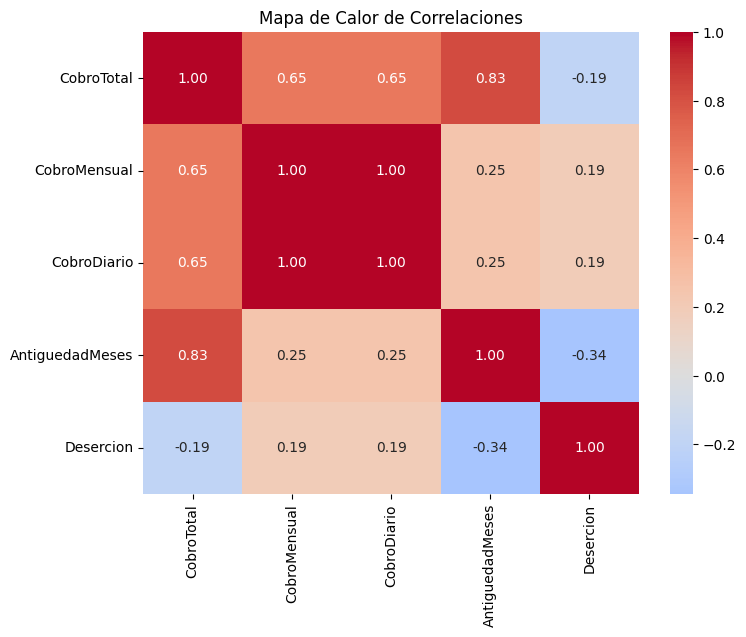

In [247]:
# Seleccionar columnas numericas relevantes para la correlacion
num_cols = ['CobroTotal', 'CobroMensual', 'CobroDiario', 'AntiguedadMeses']

# Computar la matrix de la correlation
corr = df_clean[num_cols + ['Desercion']].corr()

# Graficar heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('Mapa de Calor de Correlaciones')
plt.show()

## Desgloce de correlaciones observadas

**1. Correlación entre variables de cobro:**

*   Cobro Mensual y Cobro Diario tienen una correlación perfecta (1.0) entre sí. Esto es muy importante: sugiere que Cobro Mensual y Cobro Diario son prácticamente la misma variable o se derivan directamente una de la otra sin mucha variación.
*   Cobro Total tiene una correlación alta (0.65) con Cobro Mensual y Cobro Diario. Esto es esperable, ya que el cobro total se acumula a partir de los cobros periódicos.

**2. Correlación de Antigüedad en Meses:**

*   Antigüedad en Meses tiene una correlación fuerte con Cobro Total (0.83). Esto es lógico: cuanto más tiempo un cliente ha estado con la empresa, mayor será su cobro total acumulado.
*   Antigüedad en Meses tiene una correlación débil con Cobro Mensual y Cobro Diario (0.25). Esto es interesante, ya que sugiere que el monto que paga un cliente mensualmente o diariamente no aumenta significativamente con su antigüedad, o al menos no de forma lineal fuerte.

**3. Correlación de Deserción (Churn):**

*   Deserción y Antigüedad en Meses: Hay una correlación negativa moderada (-0.34). Esto indica que cuanto mayor es la antigüedad del cliente, menor es la probabilidad de que deserte. Los clientes más leales tienden a quedarse.
*   Deserción y Cobro Total: Hay una correlación negativa débil (-0.19). Esto sugiere que un Cobro Total acumulado más alto podría estar muy ligeramente asociado con una menor deserción, pero esta relación es mucho más débil que la de la antigüedad.
*   Deserción y Cobro Mensual / Cobro Diario: Hay una correlación positiva débil (0.19). Esto es lo más contraintuitivo y crucial: un Cobro Mensual o Cobro Diario más alto se asocia débilmente con una MAYOR probabilidad de deserción. Esto podría indicar que los clientes con facturas periódicas más altas son más propensos a irse, quizás por percibir un alto costo o buscar alternativas.

## Insights Valiosos para Modelos Predictivos Robustos

**1. Reducción de Dimensionalidad:**

*   Cobro Mensual y Cobro Diario son redundantes, dado que tienen una correlación de 1.0 entre sí.

**2. Antigüedad en Meses como Predictor Clave:**
*   La Antigüedad en Meses es un predictor muy importante para la deserción. Su correlación negativa de -0.34 indica que es una variable clave para identificar a los clientes menos propensos a la deserción. Esta variable debería tener un peso significativo.

**3. Interpretación del Cobro Mensual/Diario y la Deserción:**
*   La correlación positiva (0.19) entre Cobro Mensual/Diario y Deserción es un hallazgo intrigante.
*   Hipótesis 1: Problema de precio/valor: Los clientes que pagan más mensualmente podrían sentir que el servicio no justifica el costo, o que hay mejores ofertas en la competencia.
*   Hipótesis 2: Clientes de alto uso/demanda: Podría ser que los clientes con mayores cobros son también los que usan más servicios, lo que podría llevar a más puntos de fricción (ej., problemas de calidad, interrupciones, etc.) o simplemente más oportunidades para comparar con la competencia.

**4. Consideración de Cobro Total:**
*   Cobro Total tiene una correlación muy fuerte con Antigüedad en Meses (0.83). Aunque tiene una correlación débil con Deserción (-0.19), su información está en gran medida contenida en Antigüedad. Se podría considerar si Cobro Total añade valor predictivo adicional más allá de Antigüedad o si es redundante. Si el modelo se desempeña bien con solo Antigüedad, Cobro Total podría no ser estrictamente necesario.